In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.metrics import accuracy_score, precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay, auc, classification_report
import pickle

In [2]:
# load data
train_ads = pd.read_csv('./train_data_ads.csv.zip', compression='zip')
X = train_ads.drop(['gender'], axis=1)
y = train_ads['gender']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [3]:
from synthcity.utils.serialization import load, load_from_file, save, save_to_file
cols = ['app_score', 'app_second_class', 'series_group', 'emui_dev', 'series_dev', 'gender'] # sgd important features
data_train = pd.concat([X_train, y_train], axis=1)[cols]
features = ['app_score', 'app_second_class', 'series_group', 'emui_dev', 'series_dev'] 

## Evaluate Fidelity

In [9]:
# functions for plotting
def plot_distributions(features, orig_data, synthetic_data, outdir, outpref):
    for feature in features:
        plt.figure(figsize=(12, 8))
        plt.hist(orig_data[feature], bins=30, alpha=0.5, label='Original', color = 'blue',
                weights=np.ones(len(orig_data)) / len(orig_data))
        plt.hist(synthetic_data[feature], bins=30, alpha=0.5, label='Synthetic', color = 'gold',
                weights=np.ones(len(synthetic_data)) / len(synthetic_data))
        plt.legend(fontsize=14)
        plt.title(f'Distribution of {feature}', fontsize=20)
        plt.xlabel(feature, fontsize=16)
        plt.ylabel('Percentage', fontsize=16)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
        plt.tight_layout()
        plt.savefig(f'{outdir}/data_dist_{feature}_{outpref}.pdf')  # Change the number
        plt.close()

def plot_means(orig_data, synthetic_data, outdir, outf):
    # fidelity - compare means
    original_mean = orig_data.mean()
    synthetic_mean = synthetic_data.mean()
    
    x = np.arange(len(original_mean))
    width = 0.4
    
    plt.figure(figsize=(12, 8))
    bars1 = plt.bar(x - width / 2, original_mean.values, width, color='blue', alpha=0.6, label='Original')
    bars2 = plt.bar(x + width / 2, synthetic_mean.values, width, color='gold', alpha=0.6, label='Synthetic')
    
    for bar in bars1:
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f'{bar.get_height():.2f}',
            ha='center', va='bottom', fontsize=10
        )
    for bar in bars2:
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f'{bar.get_height():.2f}',
            ha='center', va='bottom', fontsize=10
        )
    
    plt.xticks(x, original_mean.index, rotation = 0, fontsize=12)
    plt.ylabel('Mean Value', fontsize=18)
    plt.title('Feature Means: Original vs Synthetic', fontsize=20)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig(f'{outdir}/featmeans_{outpref}.pdf')
    plt.close()

In [4]:
# read in synthetic data for gender class 3
syn_data = pd.read_csv('./privbayes/data/privbayes_gender3_frac1_sgd_imp_feats.csv')
# add synthetic data to real training data
data_train_synth = pd.concat([data_train, syn_data])
X_train_synth = data_train_synth.drop(columns='gender')
y_train_synth = data_train_synth['gender']

Plot distributions for synthetic data gender = 3 and synthetic data gender = 3 + real data

In [13]:
outdir = './privbayes/plots'
outpref = 'gender3_frac1_sgd_imp_feats_synth'
plot_distributions(cols, data_train, syn_data, outdir, outpref)

In [7]:
outpref = 'gender3_frac1_sgd_imp_feats_realsynth'
plot_distributions(cols, data_train, data_train_synth, outdir, outpref)

In [17]:
# plot correlations

import seaborn as sns

X_gender3 = data_train[data_train.gender == 3]
corr_original = X_gender3[features].corr()
corr_synthetic = syn_data[features].corr()

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

sns.heatmap(
    corr_original,
    ax=ax[0],
    cmap='Greens',
    cbar=False,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 10}
)
ax[0].set_title('Original Data Correlation', fontsize=20)

sns.heatmap(
    corr_synthetic,
    ax=ax[1],
    cmap='Greens',
    cbar=False,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 10}
)
ax[1].set_title('Synthetic Data Correlation', fontsize=20)

plt.tight_layout()
plt.savefig('./privbayes/plots/gender3_frac1_sgd_imp_feats_synth_correlations.pdf')
plt.close()

Plot distributions for synthetic data created for all classes

In [14]:
syn_data_allgender = pd.read_csv('./privbayes/data/privbayes_genderall_frac1_sgd_imp_feats_20percofreal.csv')
# add synthetic data to real training data
data_train_synth_allgender = pd.concat([data_train, syn_data_allgender])
X_train_synth_allgender = data_train_synth_allgender.drop(columns='gender')
y_train_synth_allgender = data_train_synth_allgender['gender']

outpref = 'genderall_frac1_sgd_imp_feats_20percofreal_synth'
plot_distributions(cols, data_train, syn_data_allgender, outdir, outpref)

In [18]:
# plot correlations

import seaborn as sns

corr_original = X_train[features].corr()
corr_synthetic = syn_data_allgender[features].corr()

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

sns.heatmap(
    corr_original,
    ax=ax[0],
    cmap='Greens',
    cbar=False,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 10}
)
ax[0].set_title('Original Data Correlation', fontsize=20)

sns.heatmap(
    corr_synthetic,
    ax=ax[1],
    cmap='Greens',
    cbar=False,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 10}
)
ax[1].set_title('Synthetic Data Correlation', fontsize=20)

plt.tight_layout()
plt.savefig('./privbayes/plots/genderall_frac1_sgd_imp_feats_20percofreal_synth_correlations.pdf')
plt.close()

## Evaluate Privacy

In [5]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)
test = pd.concat([X_test, y_test], axis=1)
ref, holdout = train_test_split(test[cols], test_size=0.5, random_state=1) # split x test into equally sized holdout and reference 

In [6]:
# train knn on synthetic and reference data, downsampling reference data to same size as synthetic data
ref['type'] = 0
syn_data_train = syn_data.copy()
syn_data_train['type'] = 1
train_knn = pd.concat([ref.sample(n=len(syn_data_train), random_state=1), syn_data_train]) # sample same # of ref points as synthetic
X_train_knn = train_knn[cols]
y_train_knn = train_knn['type']
neigh.fit(X_train_knn, y_train_knn)

KNeighborsClassifier()

In [8]:
# predict and calculate accuracy on holdout/training data - how similar is training data to synthetic data
train_orig = data_train.copy()[cols]
train_orig['type'] = 1
holdout['type'] = 0
targets = pd.concat([holdout, train_orig])
y_test = targets['type'] 
targets_pred = neigh.predict(targets[cols])

In [10]:
# save data
with open('./privbayes/knn_privacy.pkl', 'wb') as f:
    pickle.dump(neigh, f)
targets_pred_df = pd.DataFrame(targets_pred.T, columns=['pred'])
targets_pred_df.to_csv('./privbayes/data/knn_privacy_targets_pred.tsv')

In [11]:
# evaluate
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)
accuracy = accuracy_score(y_test, targets_pred)
precision = precision_score(y_test, targets_pred)
recall = recall_score(y_test, targets_pred)
f1 = f1_score(y_test, targets_pred)
conf_matrix = confusion_matrix(y_test, targets_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("\nClassification Report:\n")
print(classification_report(y_test, targets_pred))

Accuracy: 0.18
Precision: 0.82
Recall: 0.00
F1-Score: 0.01

Classification Report:

              precision    recall  f1-score   support

           0       0.18      1.00      0.30   1151328
           1       0.82      0.00      0.01   5372861

    accuracy                           0.18   6524189
   macro avg       0.50      0.50      0.15   6524189
weighted avg       0.71      0.18      0.06   6524189



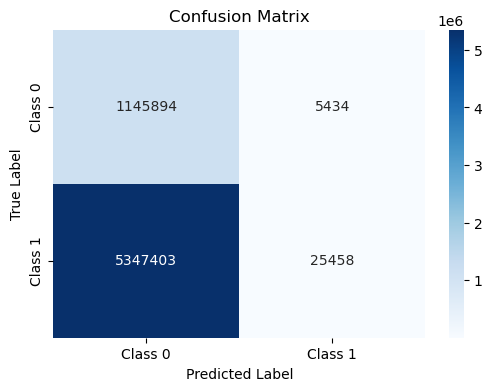

In [12]:
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Class 0", "Class 1"],
    yticklabels=["Class 0", "Class 1"],
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig(f'./privbayes/plots/privacy_confmatrix_gender3_frac1_sgd_imp_feats_synth.pdf')  # Save as PDF
plt.show()

In [ ]:
# auc on gender=3 syn data
y_proba = neigh.predict_proba(targets[cols])[:, 1]

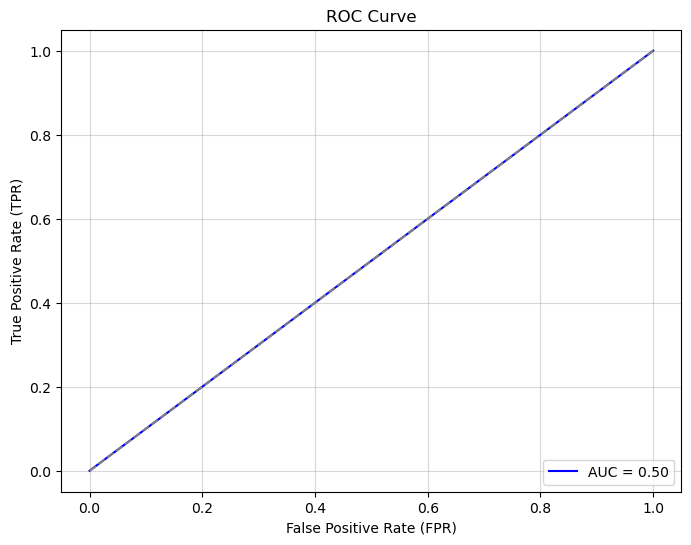

In [15]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Step 3: Calculate AUC score
auc_score = roc_auc_score(y_test, y_proba)

# Step 4: Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(alpha=0.5)
plt.savefig(f'./privbayes/plots/privacy_auc_gender3_frac1_sgd_imp_feats_synth.pdf')  # Save as PDF
plt.show()

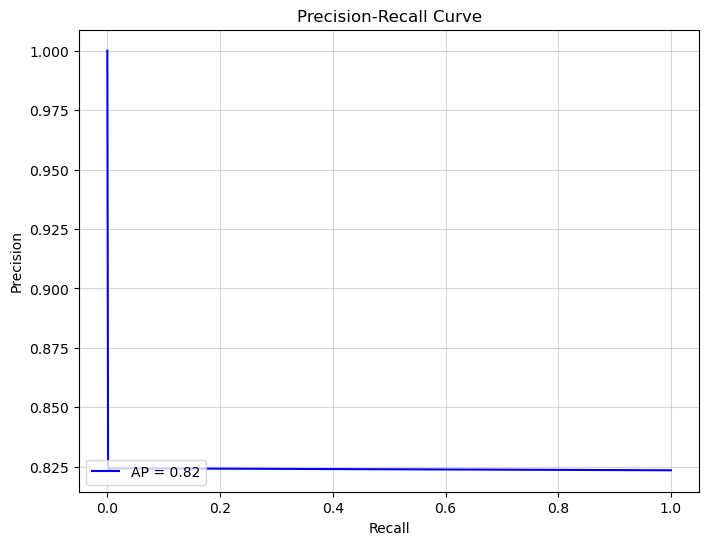

In [16]:
from sklearn.metrics import precision_recall_curve, average_precision_score
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Step 3: Calculate Average Precision (AP) score
ap_score = average_precision_score(y_test, y_proba)

# Step 4: Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label=f"AP = {ap_score:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.grid(alpha=0.5)
plt.savefig(f'./privbayes/plots/privacy_PR_gender3_frac1_sgd_imp_feats_synth.pdf')  # Save as PDF
plt.show()